# Importing Libraries

In [438]:
import sys
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import plotly
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# To import the main.py file
sys.path.append('../')
from python_files import main

from fbprophet import Prophet

In [439]:
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)


# Data Preprocessing Functions

In [440]:
def get_data():
    confirmed_global, deaths_global, recovered_global, country_cases = main.collect_data()
    
    recovered = recovered_global.groupby("country").sum().T
    deaths = deaths_global.groupby("country").sum().T
    confirmed = confirmed_global.groupby("country").sum().T
    
    deaths.index = pd.to_datetime(deaths.index, infer_datetime_format = True)
    recovered.index = pd.to_datetime(recovered.index, infer_datetime_format = True)
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format = True)
    
    return deaths, recovered, confirmed

In [441]:
def create_data_frame(dataframe,country):
    deaths, recovered, confirmed = get_data()
    if dataframe == 'deaths':
        data = pd.DataFrame(index = deaths.index, data = deaths[country].values, columns = ["Total"])

    elif dataframe == 'recovered':
        data = pd.DataFrame(index = recovered.index, data = recovered[country].values, columns = ["Total"])

    elif dataframe == 'confirmed':
        data = pd.DataFrame(index = confirmed.index, data = confirmed[country].values, columns = ["Total"])

    data = data[(data != 0).all(1)]
    
    data['Date'] = data.index
    cols = [data.columns[-1]] + [col for col in data if col != data.columns[-1]]
    data = data[cols]   

    return data

# Graphing Functions

In [442]:
def plot_forecast(data,forecast):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=data["Date"], y=data["Total"],   
                            mode='lines',
                            name='Up till now '))
        
    fig.add_trace(go.Scatter(x=forecast.index, y=forecast.values,   
                            mode='lines',
                            name='Prediction*'))

    fig.update_layout(title={
                'text': "Forecasted results",
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'},
                        template = "plotly_dark",
                        xaxis_title="Date",
                        yaxis_title="Cases",
                        legend_title="Legend ",
                        font=dict(
                                family="Arial",
                                size=15,
                                color="white"
                                )
                        )
    return fig

# Functions to Train and Test the Model

In [443]:
def find_params(train_set):
    stepwise_model = auto_arima(train_set, method='nm', start_p = 0, start_q = 0,
                               max_p = 2, max_q = 2, m = 7,
                               start_P = 0, max_P=0, start_Q=1, max_Q=1, seasonal = True,
                               d = None, D = 1, n_jobs=-1, trace = True,
                               error_action = 'ignore',  
                               suppress_warnings = True, 
                               stepwise = True)
    return stepwise_model

In [444]:
def Predict(stepwise_model,train,test):
    
    stepwise_model.fit(train)
    
    pred = stepwise_model.predict(n_periods=len(test))
    
    pred = pd.DataFrame(pred,index = test.index,columns=['Prediction'])
   
    return pred

# Error Function

In [445]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function for Forecasting

In [446]:
def Future(order,seasonal_order,train,test,data):
    
    model = SARIMAX(data['Total'],  
                        order = order,  
                        seasonal_order = seasonal_order) 
    result = model.fit() 
  
    forecast = result.predict(start = len(data),  
                          end = (len(data)-1) + 14).rename('Forecast') 
    
 
    error_check = result.predict(start = len(train), end = len(train) - 1 +len(test))
    error = mape(error_check,test)
    error = error
    graph = plot_forecast(data,forecast)

    return forecast,graph,error

# Calling Function

In [447]:
def arima_predict(df_name,country):
    data = create_data_frame(df_name,country)
    
    train = data["Total"][:len(data)*4//5]
    test = data["Total"][len(data)*4//5:]
    
    model = find_params(train)
    pred = Predict(model,train,test)
    mape_error = mape(test, pred["Prediction"])
    order=model.get_params()['order']
    seasonal_order=model.get_params()['seasonal_order']
    print("MAPE IS ",mape_error)
    forecast,graph,error = Future(order, seasonal_order, train, test,data)
    return forecast,graph,(error + np.std([error, mape_error]))

# Example

In [448]:
forecast,graph,error = arima_predict("confirmed","India")

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,1,1,7) [intercept=True]; AIC=3083.603, BIC=3093.148, Time=0.574 seconds
Fit ARIMA(0,2,0)x(0,1,0,7) [intercept=True]; AIC=3116.505, BIC=3122.869, Time=0.174 seconds
Fit ARIMA(1,2,0)x(0,1,0,7) [intercept=True]; AIC=3094.755, BIC=3104.301, Time=0.149 seconds
Fit ARIMA(0,2,1)x(0,1,1,7) [intercept=True]; AIC=3045.208, BIC=3057.935, Time=0.529 seconds
Fit ARIMA(0,2,0)x(0,1,0,7) [intercept=False]; AIC=3114.646, BIC=3117.828, Time=0.129 seconds
Fit ARIMA(0,2,1)x(0,1,0,7) [intercept=True]; AIC=3062.241, BIC=3071.787, Time=0.158 seconds
Fit ARIMA(1,2,1)x(0,1,1,7) [intercept=True]; AIC=3047.290, BIC=3063.199, Time=0.531 seconds
Fit ARIMA(0,2,2)x(0,1,1,7) [intercept=True]; AIC=3053.263, BIC=3069.172, Time=0.805 seconds
Fit ARIMA(1,2,0)x(0,1,1,7) [intercept=True]; AIC=3065.710, BIC=3078.437, Time=0.623 seconds
Fit ARIMA(1,2,2)x(0,1,1,7) [intercept=True]; AIC=3043.431, BIC=3062.522, Time=0.997 seconds
Fit ARIMA(1,2,2)x(0,1,0,7) [intercep

In [449]:
print("PREDICTIONS FOR THE NEXT 14 DAYS : \n")
for i in range(len(forecast)):
    print(forecast.index[i] , "---->", int(forecast.values[i]))

PREDICTIONS FOR THE NEXT 14 DAYS : 

2020-09-20 00:00:00 ----> 5492858
2020-09-21 00:00:00 ----> 5575629
2020-09-22 00:00:00 ----> 5666017
2020-09-23 00:00:00 ----> 5764985
2020-09-24 00:00:00 ----> 5862695
2020-09-25 00:00:00 ----> 5960004
2020-09-26 00:00:00 ----> 6057036
2020-09-27 00:00:00 ----> 6152679
2020-09-28 00:00:00 ----> 6239378
2020-09-29 00:00:00 ----> 6333642
2020-09-30 00:00:00 ----> 6436376
2020-10-01 00:00:00 ----> 6537935
2020-10-02 00:00:00 ----> 6639071
2020-10-03 00:00:00 ----> 6739920


In [450]:
graph.show()

In [451]:
print("ALLOW AN ERROR OF UPTO (Based on the data at hand) :",error,"%")

ALLOW AN ERROR OF UPTO (Based on the data at hand) : 1.6933650380299519 %


In [452]:
data = create_data_frame("confirmed","India")
data.columns=['ds','y']
# data['Day']=data['ds'].dt.dayofweek
# data['day_of_year'] = data['ds'].dt.dayofyear
# data['week_of_year'] = data['ds'].dt.weekofyear
# data['isWeekend'] = (data['Day'] // 5 == 1).astype(int)
data['y']=data['y'].diff()
data=data[1:]
data

,ds,y
2020-01-31,2020-01-31,0.0
2020-02-01,2020-02-01,0.0
2020-02-02,2020-02-02,1.0
2020-02-03,2020-02-03,1.0
2020-02-04,2020-02-04,0.0
...,...,...
2020-09-15,2020-09-15,90123.0
2020-09-16,2020-09-16,97894.0
2020-09-17,2020-09-17,96424.0
2020-09-18,2020-09-18,93337.0


In [453]:
prophet= Prophet (growth="linear",
                  seasonality_mode="additive",
                  changepoint_prior_scale=30,
                  seasonality_prior_scale=35,
                  daily_seasonality=False,
                  weekly_seasonality=False,
                  yearly_seasonality=False,).add_seasonality(name="monthly",period=30.5,fourier_order=55).add_seasonality(name="weekly",period=7,fourier_order=15).add_seasonality(name="daily",period=1,fourier_order=15)

In [454]:
# prophet.add_regressor('isWeekend')
# # prophet.add_regressor('Day')
# prophet.add_regressor('day_of_year')
# prophet.add_regressor('week_of_year')

In [455]:
prophet.fit(data)

In [456]:
future=prophet.make_future_dataframe(freq='D',periods=14)
# future['Day']=future['ds'].dt.dayofweek
# future['day_of_year'] = future['ds'].dt.dayofyear
# future['week_of_year'] = future['ds'].dt.weekofyear
# future['isWeekend'] = (future['Day'] // 5 == 1).astype(int)
forecast=prophet.predict(future)
# forecast.columns

In [457]:
forecast['yhat']


0        1058.541602
1         388.128825
2        -819.935145
3       -2432.922303
4       -1988.360294
           ...      
242     97697.770678
243    103298.873338
244    100338.131142
245    100976.999752
246    100999.557816
Name: yhat, Length: 247, dtype: float64

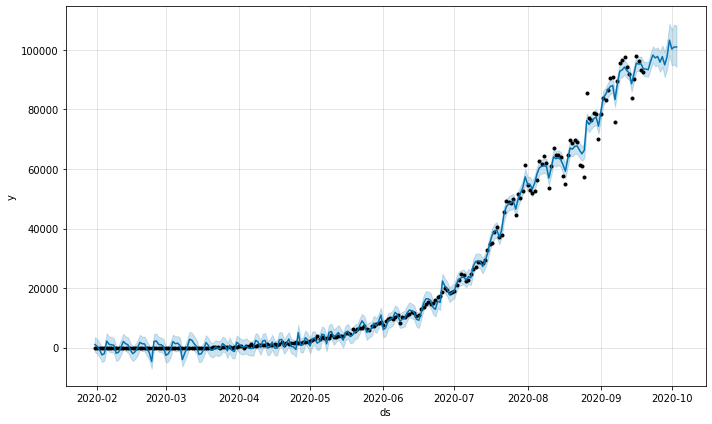

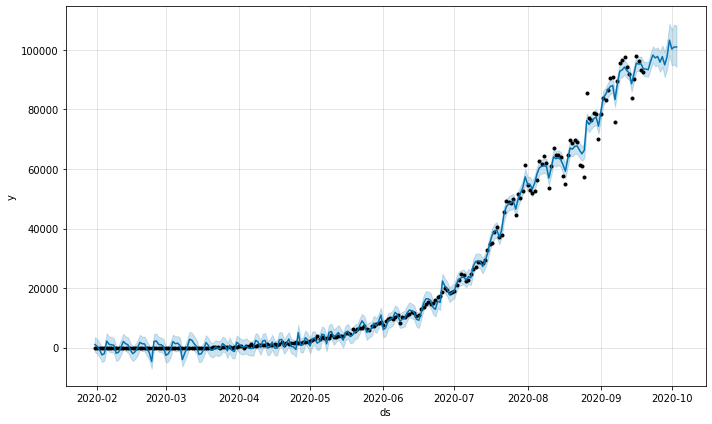

In [458]:
prophet.plot(forecast)

In [459]:
avg=sum(data.diff()[len(data)-14:]['y'])/14
avg

140.92857142857142

In [460]:
# for i in range(1,len(forecast)):
#     if forecast['yhat'][i]<forecast['yhat'][i-1]:
#         forecast['yhat'][i]=forecast['yhat'][i-1]+avg


In [461]:
# sum(data['y'][data.index[:50]])
L=[]
for i in range(len(data['y'].values)):
    L.append(sum(data['y'].values[:i]))
data['y']=L

In [462]:
L=[]
for i in range(len(forecast['yhat'])):
    L.append(sum(forecast['yhat'].values[:i]))
forecast['yhat']=L


In [463]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophet,initial=f'{0.8*len(data)} days',period='7 days',horizon = '14 days')


INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-08-08 00:00:00 and 2020-09-05 00:00:00


In [464]:
for i in range(len(df_cv)):
    df_cv.yhat.values[i]=int(df_cv.yhat.values[i])
# mpe=mape(df_cv.y,df_cv.yhat)
# mpe

In [466]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,7.591567e+07,8712.959622,8099.085714,0.129618,0.140451,0.114286
1,3 days,6.110582e+07,7817.021422,6032.542857,0.098620,0.071256,0.285714
2,4 days,3.422488e+07,5850.203047,3571.514286,0.048760,0.024845,0.542857
3,5 days,1.333750e+07,3652.053559,2513.942857,0.032418,0.024845,0.457143
4,6 days,6.380346e+06,2525.934611,1808.514286,0.025107,0.011417,0.685714
5,7 days,1.042041e+07,3228.066710,2490.000000,0.033492,0.026676,0.657143
6,8 days,4.460138e+07,6678.426769,5253.714286,0.078283,0.059378,0.457143
7,9 days,1.239216e+08,11132.009709,10104.742857,0.150813,0.126412,0.114286
8,10 days,9.382579e+07,9686.371320,8241.571429,0.121539,0.126412,0.285714
9,11 days,5.872419e+07,7663.170759,6007.285714,0.076982,0.082774,0.400000


In [467]:
ftr = (data.index + pd.Timedelta(14, unit='days')).to_frame()
ftr=ftr[len(ftr)-14:]
ftr['Total']=forecast[len(data):]['yhat'].values
ftr=ftr['Total']
ftr
# for i in range(len(ftr)):
#     if(ftr[i]>ftr[i+1]):
#         ftr[i+1]=int(ftr[i]+avg)
#     else:
#         ftr[i+1]=int(ftr[i+1])
# ftr

2020-09-20    5.400635e+06
2020-09-21    5.494181e+06
2020-09-22    5.587557e+06
2020-09-23    5.683585e+06
2020-09-24    5.781865e+06
2020-09-25    5.879173e+06
2020-09-26    5.976982e+06
2020-09-27    6.072878e+06
2020-09-28    6.170641e+06
2020-09-29    6.265607e+06
2020-09-30    6.363305e+06
2020-10-01    6.466604e+06
2020-10-02    6.566942e+06
2020-10-03    6.667919e+06
Freq: D, Name: Total, dtype: float64

In [468]:
L=[]
for i in range(len(df_cv['yhat'])):
    L.append(sum(df_cv['yhat'].values[:i]))
df_cv['yhat']=L
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-09,0.0,61933.208417,64182.197897,62064.0,2020-08-08
1,2020-08-10,63134.0,62315.902897,64569.817135,53601.0,2020-08-08
2,2020-08-11,126597.0,64120.842326,66455.663487,60963.0,2020-08-08
3,2020-08-12,191904.0,66054.826001,68550.506440,66999.0,2020-08-08
4,2020-08-13,259276.0,67611.002391,70484.791048,64553.0,2020-08-08
...,...,...,...,...,...,...
65,2020-09-15,5125205.0,96759.613063,104268.716723,90123.0,2020-09-05
66,2020-09-16,5225750.0,99653.700491,107942.650041,97894.0,2020-09-05
67,2020-09-17,5329475.0,100194.474894,109482.177087,96424.0,2020-09-05
68,2020-09-18,5434298.0,102028.884765,112425.484405,93337.0,2020-09-05


In [469]:
L=[]
for i in range(len(df_cv['y'])):
    L.append(sum(df_cv['y'].values[:i]))
df_cv['y']=L

In [470]:
mape(df_cv['y'][1:],df_cv['yhat'][1:])

6.369914302342836

In [471]:
def plot_forecast(data,forecast):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=data["ds"], y=data["y"],   
                            mode='lines',
                            name='Up till now '))
        
    fig.add_trace(go.Scatter(x=forecast.index, y=forecast.values,   
                            mode='lines',
                            name='Prediction*'))

    fig.update_layout(title={
                'text': "Forecasted results",
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'},
                        template = "plotly_dark",
                        xaxis_title="Date",
                        yaxis_title="Cases",
                        legend_title="Legend ",
                        font=dict(
                                family="Arial",
                                size=15,
                                color="white"
                                )
                        )
    return fig

In [472]:
plot_forecast(data,ftr2)